# We only calculate the E and B mode maps on a small portion of the sky. 
We do this by constructing a mask near the equator and evaluating the E and B modes only on pixels not masked.
We do use the all the Stokes Q and U maps however. So we dont have to worry about masking while evaluating these 
E and B mode maps.

In [45]:
import healpy as h
import sys  ; sys.path.append("../../codes/")
from modules import local_eb_kernel_masked as rk
from scipy.integrate import quad
import os
import timeit

%pylab notebook

Populating the interactive namespace from numpy and matplotlib


/Users/adityarotti/Library/Enthought/Canopy/edm/envs/User/lib/python2.7/site-packages/IPython/core/magics/pylab.py:161: UserWarning: pylab import has clobbered these variables: ['rc']
`%matplotlib` prevents importing * from pylab and numpy
  "\n`%matplotlib` prevents importing * from pylab and numpy"


In [2]:
respath="../../figures/simulated/high_res_qu2eb/"
!mkdir $respath

figpath=respath
datapath=respath + "generated_data/"
!mkdir $datapath
genplots=True
nomask=True

In [3]:
nside=512 ; upnside=nside ; npix=h.nside2npix(upnside)
lmax=3*nside ; lmin=2
ell=arange(lmax+1)
fll=ell*(ell+1)/(2.*pi)

odisc=min(180.,180.*(24./lmax))
print odisc

2.8125


In [4]:
from matplotlib import rcParams,rc
params = {'backend': 'pdf',
          'savefig.dpi': 200,
          'axes.labelsize': 15,
          'text.fontsize': 15,
          'axes.linewidth' : 2,
          'lines.linewidth' : 2,
          'font.size': 15,
          'xtick.labelsize': 15,
          'ytick.major.pad': 6,
          'xtick.major.pad': 6,
          'ytick.labelsize': 15,
          'text.usetex': True,
          'font.family':'sans-serif',
          'font.sans-serif':'FreeSans',
          'image.cmap':'jet'}
rc('text.latex', preamble='\usepackage{sfmath}')
rcParams.update(params)

/Users/adityarotti/Library/Enthought/Canopy/edm/envs/User/lib/python2.7/site-packages/matplotlib/__init__.py:913: UserWarning: text.fontsize is deprecated and replaced with font.size; please use the latter.
  warnings.warn(self.msg_depr % (key, alt_key))


In [5]:
cltemp=h.read_cl("../../data/planck_wp_highL_lensing_param.fits")
cl=[cltemp[0],cltemp[1],cltemp[2],cltemp[3]*0] # Reverse E and B spectra

#cl=[cltemp[0],cltemp[2],cltemp[1],cltemp[3]*0] # Reverse E and B spectra
#figpath="../article/figures/complementary/"

random.seed(0) ; tqu=h.synfast(cl,nside,pol=True,new=True,verbose=False)

# Get teb maps from Healpix.
alm=h.map2alm(tqu,lmax=3*nside,pol=True) ; teb=h.alm2map(alm,upnside,pol=False,verbose=False)

# Get data power spectrum.
cld=h.alm2cl(alm)

# Get Q/U corresponding to E and B modes.
alm[2][:]=0.0 ; equ=h.alm2map(alm,nside=nside,pol=True,verbose=False)
alm=h.map2alm(tqu,lmax=3*nside,pol=True) ; alm[1][:]=0.0 ; bqu=h.alm2map(alm,nside=nside,pol=True,verbose=False)

fl=ones(3*nside+1,float) ; fl[:lmin+1]=0

<IPython.core.display.Javascript object>


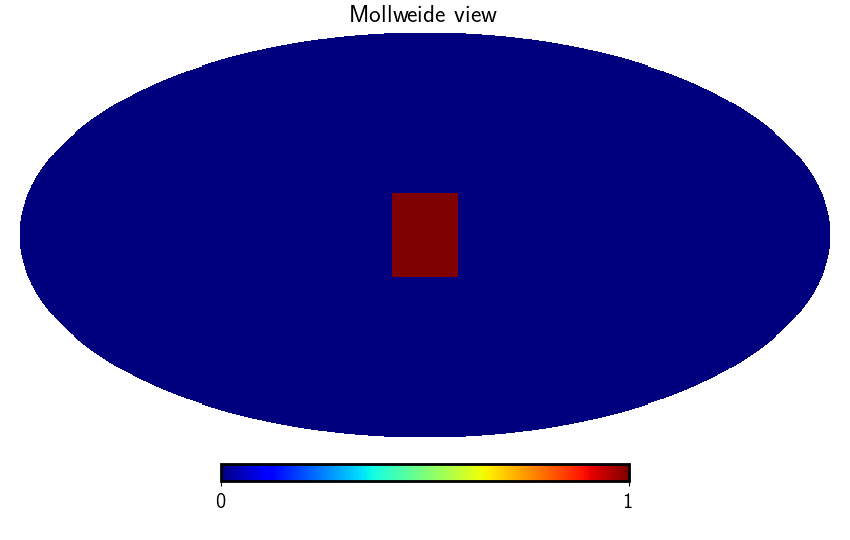

In [33]:
tmask=zeros(npix,float)
pmask=zeros(npix,float)
pindex=arange(npix)
theta,phi=h.pix2ang(nside,pindex)
theta=theta*180/pi ; phi=phi*180/pi
wband=75 ; phiband=15
tmask[theta<wband]=1 ; tmask[theta>180-wband]=1.
pmask[phi<phiband]=1. ; pmask[phi>360-phiband]=1.
mask=pmask*(1-tmask)
h.mollview(mask)

In [58]:
y=rk.real_space_queb_kernels(nside,tmax=2.2*odisc,maxlmax=3*nside,sampling=2500)
y.calc_qu2eb_rad_kernel(lmax,lmin)
y.calc_qu2queb_rad_kernel(lmax,lmin)

y.setup_taper(2.2*odisc,2.) ; y.setup_fn_rad_ker()

In [75]:
pindex=nonzero(mask)[0]
rteb0=y.convert_qu2eb(tqu,discsize=2.*odisc,pindex=pindex)
h.write_map(datapath + "rteb_2beta_nside512.fits",rteb0)

In [108]:
pindex=nonzero(mask)[0]
rteb1=y.convert_qu2eb(tqu,discsize=1.*odisc,pindex=pindex)
h.write_map(datapath + "rteb_1beta_nside512.fits",rteb0)

In [96]:
h.write_map(datapath + "mask.fits",mask)
h.write_map(datapath + "fsteb.fits",teb)

In [109]:
clrteb0=h.alm2cl(h.map2alm(rteb0,lmax=3*nside,pol=False))
clrteb1=h.alm2cl(h.map2alm(rteb1,lmax=3*nside,pol=False))
cld=h.alm2cl(h.map2alm(teb*mask,lmax=3*nside,pol=False))

<IPython.core.display.Javascript object>


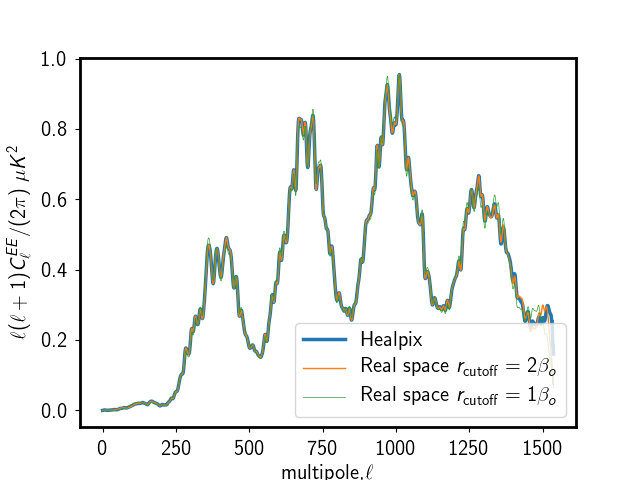

<IPython.core.display.Javascript object>


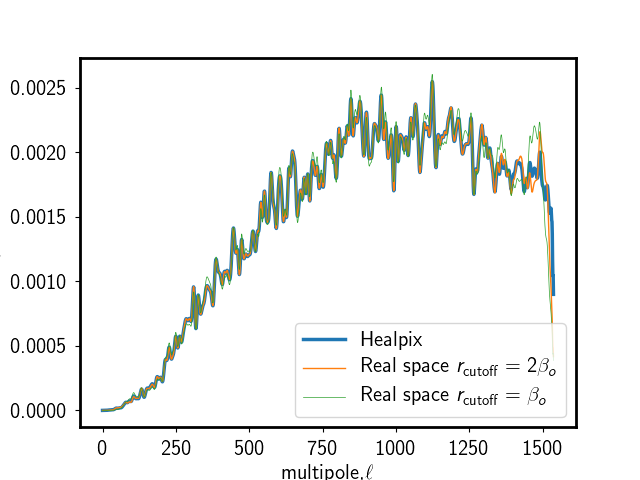

In [112]:
figure()
plot(ell,fll*cld[1],lw=2.5,label="Healpix")
plot(ell,fll*clrteb0[1],"-",lw=1,label=r"Real space $r_{\rm cutoff}=2\beta_o$")
plot(ell,fll*clrteb1[1],"-",lw=0.5,label=r"Real space $r_{\rm cutoff}=\beta_o$")
legend(loc=0)
xlabel("multipole,$\ell$")
ylabel("$\ell (\ell+1) C^{EE}_{\ell}/(2 \pi)~ \mu K^2$")
if genplots:
    savefig(figpath + "ee-spectrum-2beta-nside512.pdf",dpi=300,bbox_inches="tight")
    
    
figure()
plot(ell,fll*cld[2],lw=2.5,label="Healpix")
plot(ell,fll*clrteb0[2],"-",lw=1.,label=r"Real space $r_{\rm cutoff}=2\beta_o$")
plot(ell,fll*clrteb1[2],"-",lw=0.5,label=r"Real space $r_{\rm cutoff}=\beta_o$")
legend(loc=0)
xlabel("multipole,$\ell$")
ylabel("$\ell (\ell+1) C^{BB}_{\ell}/(2 \pi)~ \mu K^2$")
if genplots:
    savefig(figpath + "bb-spectrum-2beta-nside512.pdf",dpi=300,bbox_inches="tight")

<IPython.core.display.Javascript object>


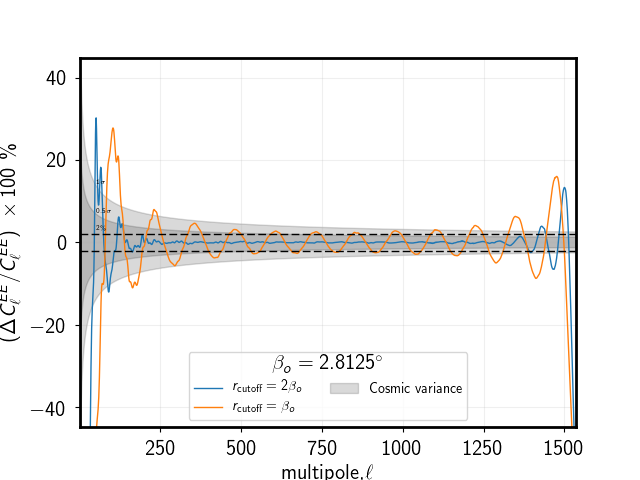

<IPython.core.display.Javascript object>


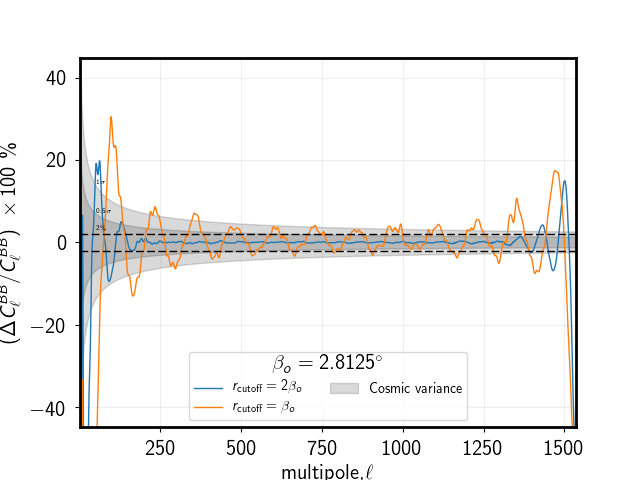

In [113]:
figure()
std=cld[1]/100.
plot(ell,(clrteb0[1]-cld[1])/std,lw=1,label=r"$r_{\rm cutoff} = 2\beta_{o}$")
plot(ell,(clrteb1[1]-cld[1])/std,lw=1,label=r"$r_{\rm cutoff} = \beta_{o}$")
fill_between(ell,-sqrt(2./(2.*ell+1))*100,sqrt(2./(2.*ell+1))*100,color="black",alpha=0.15,label="Cosmic variance")
fill_between(ell,-0.5*sqrt(2./(2.*ell+1))*100,0.5*sqrt(2./(2.*ell+1))*100,color="black",alpha=0.15,label="")
ylim(-45,45)
xlim(2,3*nside)
xlabel("multipole,$\ell$")
ylabel(r"$(\Delta C^{EE}_{\ell}/C^{EE}_{\ell}) ~\times 100 ~\%$")
legend(loc="lower center",fontsize=10,ncol=2,title=r"$\beta_o=" + str(odisc) + "^{\circ}$")
axhline(-2,0,200,linestyle="dashed",alpha=1,color="k",lw=1)
axhline(2,0,200,linestyle="dashed",alpha=1,color="k",lw=1)
grid(alpha=0.2,linestyle="solid")
text(52,14.2,r"$1 \sigma$",fontsize=5)
text(51,7.2,r"$0.5 \sigma$",fontsize=5)
text(51,2.8,r"$2 \%$",fontsize=5)

if genplots:
    savefig(figpath + "relative-percentage-err-ee-spectrum-radial-cutoff.pdf",dpi=300,bbox_inches="tight")
    
    
figure()
std=cld[2]/100.
plot(ell,(clrteb0[2]-cld[2])/std,lw=1,label=r"$r_{\rm cutoff} = 2\beta_{o}$")
plot(ell,(clrteb1[2]-cld[2])/std,lw=1,label=r"$r_{\rm cutoff} = \beta_{o}$")
fill_between(ell,-sqrt(2./(2.*ell+1))*100,sqrt(2./(2.*ell+1))*100,color="black",alpha=0.15,label="Cosmic variance")
fill_between(ell,-0.5*sqrt(2./(2.*ell+1))*100,0.5*sqrt(2./(2.*ell+1))*100,color="black",alpha=0.15,label="")
ylim(-45,45)
xlim(2,3*nside)
xlabel("multipole,$\ell$")
ylabel(r"$(\Delta C^{BB}_{\ell}/C^{BB}_{\ell}) ~\times 100 ~\%$")
legend(loc="lower center",fontsize=10,ncol=2,title=r"$\beta_o=" + str(odisc) + "^{\circ}$")
axhline(-2,0,200,linestyle="dashed",alpha=1,color="k",lw=1)
axhline(2,0,200,linestyle="dashed",alpha=1,color="k",lw=1)
grid(alpha=0.2,linestyle="solid")
text(52,14.2,r"$1 \sigma$",fontsize=5)
text(51,7.2,r"$0.5 \sigma$",fontsize=5)
text(51,2.8,r"$2 \%$",fontsize=5)

if genplots:
    savefig(figpath + "relative-percentage-err-bb-spectrum-radial-cutoff.pdf",dpi=300,bbox_inches="tight")